<a href="https://colab.research.google.com/github/aankit/nycdoe_space_analysis/blob/master/DOE_Space_with_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Understanding Physical Space in the Largest School District in the United States

New York City has the largest school district in the country based on the number of students it serves. The COVID-19 pandemic has asked us all to be more cognizant of our physical space whether it be staying 6 feet apart in public or staying sane at home, especially if you live in a tiny NYC apartment.

###How much physical space does each student have in NYC schools? How does the space per student differ between schools and is there a potential disparate impact? 

Feel free to reach out to me at hi@aankit.com if you have questions or thoughts.

###Question 1: Does publicly available data about the physical space of schools exist?

Yes! Below I point out and load up some data sources for an analysis.

First I'm going to install and load some helpful tools :)

In [1]:
from __future__ import print_function
import requests
import pandas as pd
import io
import numpy as np

DOE Building Space Usage is available on the NYC Open Data Portal [here](https://data.cityofnewyork.us/Education/DOE-Building-Space-Usage/wavz-fkw8). I'm using the CSV because the [JSON API endpoint](https://data.cityofnewyork.us/resource/wavz-fkw8.json) only yields 1000 rows at a time I don't feel like writing a loop to page through.

In [2]:
response = requests.get("https://data.cityofnewyork.us/api/views/wavz-fkw8/rows.csv?accessType=DOWNLOAD")
school_space = pd.read_csv(io.StringIO(response.text))

Attendance history will give us a somewhat accurate picture of how many students are in each building.

In [3]:
response = requests.get("https://data.cityofnewyork.us/api/views/vww9-qguh/rows.csv?accessType=DOWNLOAD")
attendance_history = pd.read_csv(io.StringIO(response.text))

We will need more information schools - like what grades they serve and where they are located for a proper analysis. 

DOE School Information is available via a file called "LCGMS" [here](https://data.cityofnewyork.us/Education/LCGMS-DOE-School-Information-Report/3bkj-34v2). I'm using the [CSV with additional geocoded fields](https://data.cityofnewyork.us/api/views/3bkj-34v2/files/56813139-9b9d-44fb-b81d-068553b7a9b7?download=true&filename=LCGMS_SchoolData(additional%20geocoded%20fields%20added).csv)

In [4]:
response = requests.get("https://data.cityofnewyork.us/api/views/3bkj-34v2/files/56813139-9b9d-44fb-b81d-068553b7a9b7?download=true&filename=LCGMS_SchoolData(additional geocoded fields added).csv")
lcgms = pd.read_csv(io.StringIO(response.text))

And finally we will want to look at all of this on a map, so let's load a geospatial file of school zones from [here](https://data.cityofnewyork.us/Education/2019-2020-School-Zones-Elementary-/kuk3-ypca). I'm using the shapefile.

This is only relevant for elementary schools (and maybe some middle schools).

In [5]:
response = requests.get("https://data.cityofnewyork.us/api/views/69ip-ny7p/rows.csv?accessType=DOWNLOAD")
school_zones = pd.read_csv(io.StringIO(response.text))

###Question 2: What areas of a school are instructional areas?

The data dictionary provided by the School Construction Authority on the  NYC Open Data Portal is helpful. It tells us that the DOE Building Space data we pulled in and named `school_space` has a `Room Function` column, or field. Let's get a count of the values in the `Room Function` field.

In [6]:
school_space["Room Function"].value_counts()

REGULAR CLASSROOM                70581
STORAGE ROOM                     46699
OTHER OFFICE                     36936
GENERAL BUILDING SUPPORT         31838
REGULAR CLASSROOM - MS GRADES    19807
                                 ...  
ELEVENTH GRADE                      94
GYM/AUD/CAFETERIA                   89
DRAFTING ROOM                       73
TWELFTH GRADE                       51
NEST NINTH-TWELFTH GRADE            13
Name: Room Function, Length: 109, dtype: int64

Based on this quick overview, if `Room Function` contains the word "classroom" or "grade" it can probably be classified as an instructional space.

In [7]:
instructional_school_space = school_space[school_space["Room Function"].str.contains("CLASSROOM|GRADE", na=False)]
instructional_school_space["Room Function"].value_counts()

REGULAR CLASSROOM                   70581
REGULAR CLASSROOM - MS GRADES       19807
D75 SPED CLASSROOM                  15482
NON-D75 SPED CLASSROOM              15481
FIRST GRADE                         13521
SECOND GRADE                        12696
THIRD GRADE                         12193
FOURTH GRADE                        11622
FIFTH GRADE                         11369
ICT - ELEMENTARY SCHOOL GRADES      10215
REGULAR CLASSROOM - HS GRADES        3813
MULTI-PURPOSE CLASSROOM              2544
SCIENCE CLASSROOM FOR PS             2028
SIXTH GRADE                          1644
ICT - MIDDLE SCHOOL GRADES           1558
SEVENTH GRADE                        1526
EIGHTH GRADE                         1482
MULTI-PURPOSE NON CLASSROOM          1177
NEST FIRST-THIRD GRADE                452
ICT - HIGH SCHOOL GRADES              424
NEST SIXTH-EIGHTH GRADE               407
NEST FOURTH-FIFTH GRADE               248
NINTH GRADE                           236
HORIZON SECOND-TWELFTH GRADE      

Let's take a look at the square footage of this instructional space. This view is aggregating across schools. The next step is to drill down to the school level before we link schools to the communities they serve.

In [8]:
instructional_school_space.groupby("Room Function").sum()

,Length,Width,Area
Room Function,,,
D75 SPED CLASSROOM,372679.0,345510.0,8302789.0
EIGHTH GRADE,37973.0,40526.0,1031246.0
ELEVENTH GRADE,2529.0,2424.0,64696.0
FIFTH GRADE,281419.0,300719.0,7362002.0
FIRST GRADE,339764.0,352957.0,8773473.0
FOURTH GRADE,287273.0,306075.0,7479172.0
HORIZON KINDERGARTEN-FIRST GRADE,2509.0,2243.0,58305.0
HORIZON SECOND-TWELFTH GRADE,5293.0,5087.0,127132.0
ICT - ELEMENTARY SCHOOL GRADES,255937.0,269540.0,6657939.0


Looks we are including a few `MULTI-PURPOSE` rooms that are `NON-CLASSROOMS`. Let's remove those.

Also, we can estimate the number of teachers in a building based on the number of rooms. Let's add that in:
*   2 teachers for each non D75 rooms
*   4 teachers for each D75 room

In [9]:
instructional_school_space = instructional_school_space[~instructional_school_space["Room Function"].str.contains("NON CLASSROOM", na=False)]
instructional_school_space.loc[instructional_school_space["Room Function"].str.contains("D75"), "Num Teachers"] = 4
instructional_school_space.loc[~instructional_school_space["Room Function"].str.contains("D75"), "Num Teachers"] = 2
instructional_school_space.groupby("Room Function").head()


,Bldg ID,Org Code,Room Number,Length,Width,Area,Room Function,Data As Of,Num Teachers
1,K001,K001,102,29.0,33.0,957.0,SECOND GRADE,06/04/2015,2.0
4,K001,K001,106,29.0,32.0,928.0,FIRST GRADE,06/04/2015,2.0
22,K001,K001,201,26.0,27.0,702.0,THIRD GRADE,06/04/2015,2.0
23,K001,K001,202,27.0,27.0,729.0,FIRST GRADE,06/04/2015,2.0
24,K001,K001,203,27.0,26.0,702.0,FIFTH GRADE,06/04/2015,2.0
...,...,...,...,...,...,...,...,...,...
99200,K055,K493,420,25.0,27.0,675.0,ICT - HIGH SCHOOL GRADES,09/12/2017,2.0
99352,K057,K688,110,32.0,23.0,736.0,ICT - HIGH SCHOOL GRADES,09/12/2017,2.0
124488,K460,K464,401,27.0,21.0,567.0,ICT - HIGH SCHOOL GRADES,09/12/2017,2.0
124499,K460,K464,414,24.0,20.0,480.0,ICT - HIGH SCHOOL GRADES,09/12/2017,2.0


###Question 3: Can we determine each school's square footage per person?

The `Contributing 20+ Total Days` field in `attendance_history` tells us how many students spend 20 or more days at the each school. This slightly inflates annual attendance numbers, but also captures the fact that NYC schools deal with fluctuating attendance due to students joining and leaving.

We can focus on the most recent year's attendance, but there are numbers going back to 2013-14 allowing for historical analysis. Finally the data also provides attendance by grade and demographic category, but again for simplicity we can look at the aggregate of all students for the school.

In [10]:
attendance = attendance_history[(attendance_history["Year"].eq("2018-19")) & (attendance_history["Grade"].eq("All Grades")) & (attendance_history["Demographic Category"].eq("All Students"))]
attendance.head(15)

,DBN,School Name,Grade,Year,Demographic Category,Demographic Variable,# Total Days,# Days Absent,# Days Present,% Attendance,# Contributing 20+ Total Days,# Chronically Absent,% Chronically Absent
5,01M015,P.S. 015 Roberto Clemente,All Grades,2018-19,All Students,All Students,30887,2278,28609,92.6,186,45,24.2
54,01M019,P.S. 019 Asher Levy,All Grades,2018-19,All Students,All Students,44723,3979,40744,91.1,265,87,32.8
102,01M020,P.S. 020 Anna Silver,All Grades,2018-19,All Students,All Students,85659,6800,78859,92.1,511,160,31.3
151,01M034,P.S. 034 Franklin D. Roosevelt,All Grades,2018-19,All Students,All Students,54863,6309,48554,88.5,323,152,47.1
218,01M063,The STAR Academy - P.S.63,All Grades,2018-19,All Students,All Students,40842,3731,37111,90.9,247,83,33.6
267,01M064,P.S. 064 Robert Simon,All Grades,2018-19,All Students,All Students,40702,4604,36098,88.7,240,115,47.9
315,01M110,P.S. 110 Florence Nightingale,All Grades,2018-19,All Students,All Students,64913,3960,60953,93.9,388,92,23.7
364,01M134,P.S. 134 Henrietta Szold,All Grades,2018-19,All Students,All Students,51585,5514,46071,89.3,311,148,47.6
437,01M140,P.S. 140 Nathan Straus,All Grades,2018-19,All Students,All Students,67989,7814,60175,88.5,409,198,48.4
507,01M142,P.S. 142 Amalia Castro,All Grades,2018-19,All Students,All Students,62653,5790,56863,90.8,370,137,37.0


Let's take some columns from `attendance_history` and combine it with the `instructional_school_space` and do a calculation of square foot per student.

In [11]:
instructional_rooms = instructional_school_space[["Org Code", "Room Number"]].groupby(["Org Code"]).count()
instructional_area = instructional_school_space[["Org Code", "Area", "Num Teachers"]].groupby("Org Code").sum()
instructional_space_by_school = pd.merge(instructional_rooms, instructional_area, on="Org Code")
instructional_space_by_school.columns = ["Num Rooms", "Area", "Num Teachers"]
instructional_space_by_school

,Num Rooms,Area,Num Teachers
Org Code,,,
K001,200,127110.0,440.0
K002,128,87958.0,304.0
K003,93,64592.0,204.0
K004,293,163672.0,1118.0
K005,93,66941.0,226.0
...,...,...,...
X996,21,13151.0,42.0
X997,7,5610.0,14.0
XADM,2,1615.0,4.0


In [12]:
iss_lcgms = pd.merge(instructional_space_by_school, lcgms, left_on="Org Code", right_on="Location Code")
all_data = pd.merge(attendance, iss_lcgms, left_on="DBN", right_on="ATS System Code")
all_data.head()

,DBN,School Name,Grade,Year,Demographic Category,Demographic Variable,# Total Days,# Days Absent,# Days Present,% Attendance,# Contributing 20+ Total Days,# Chronically Absent,% Chronically Absent,Num Rooms,Area,Num Teachers,ATS System Code,Location Code,Location Name,BEDS Number,Managed By Name,Location Type Description,Location Category Description,Grades,Grades Final,Open Date,Status Description,Building Code,Primary Address,City,State Code,Zip,Borough Block Lot,Census Tract,Community District,Council District,NTA,NTA_Name,Principal Name,Principal Title,Principal Phone Number,Fax Number,Geographical District Code,Administrative District Code,Administrative District Location Code,Administrative District Name,Superintendent,Superintendent Location Code,Community School Sup Name,BFSC Location Code,BFSC Director Name,BFSC Director Title,BFSC Director Phone,HighSchool Network Location Code,HighSchool Network Name,HighSchool Network Superintendent,Borough,BIN,Latitude,Longitude
0,01M015,P.S. 015 Roberto Clemente,All Grades,2018-19,All Students,All Students,30887,2278,28609,92.6,186,45,24.2,49,29680.0,98.0,01M015,M015,P.S. 015 Roberto Clemente,3.100000e+11,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",Jul 1 1904,Open,M015,333 EAST 4 STREET,MANHATTAN,NY,10009,1003740020,2601.0,103,2,MN28,Lower East Side,IRENE SANCHEZ,PRINCIPAL,212-228-8730,212-477-0931,1,1,M801,COMMUNITY SCHOOL DISTRICT 01,"PHILLIPS, DANIELLA",M801,"PHILLIPS, DANIELLA",MFSC,"CHU, YUET",FSC Executive Director,646-470-0721,NaN,NaN,NaN,MANHATTAN,,40.721807,-73.979022
1,01M019,P.S. 019 Asher Levy,All Grades,2018-19,All Students,All Students,44723,3979,40744,91.1,265,87,32.8,79,55955.0,182.0,01M019,M019,P.S. 019 Asher Levy,3.100000e+11,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",Jul 1 1956,Open,M019,185 1 AVENUE,MANHATTAN,NY,10003,1004530034,4000.0,103,2,MN22,East Village,JACQUELINE FLANAGAN,PRINCIPAL,212-533-5340,212-673-1477,1,1,M801,COMMUNITY SCHOOL DISTRICT 01,"PHILLIPS, DANIELLA",M801,"PHILLIPS, DANIELLA",MFSC,"CHU, YUET",FSC Executive Director,646-470-0721,NaN,NaN,NaN,MANHATTAN,,40.729636,-73.983818
2,01M020,P.S. 020 Anna Silver,All Grades,2018-19,All Students,All Students,85659,6800,78859,92.1,511,160,31.3,114,73384.0,258.0,01M020,M020,P.S. 020 Anna Silver,3.100000e+11,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",Jul 1 1963,Open,M020,166 ESSEX STREET,MANHATTAN,NY,10002,1003550001,3001.0,103,1,MN27,Chinatown,SARAH PINTO VIAGRAN,PRINCIPAL,212-254-9577,212-254-3526,1,1,M801,COMMUNITY SCHOOL DISTRICT 01,"PHILLIPS, DANIELLA",M801,"PHILLIPS, DANIELLA",MFSC,"CHU, YUET",FSC Executive Director,646-470-0721,NaN,NaN,NaN,MANHATTAN,,40.721540,-73.986648
3,01M034,P.S. 034 Franklin D. Roosevelt,All Grades,2018-19,All Students,All Students,54863,6309,48554,88.5,323,152,47.1,78,51898.0,160.0,01M034,M034,P.S. 034 Franklin D. Roosevelt,3.100000e+11,DOE,General Academic,K-8,"PK,0K,01,02,03,04,05,06,07,08,SE","PK,0K,01,02,03,04,05,06,07,08",Jul 1 1955,Open,M034,730 EAST 12 STREET,MANHATTAN,NY,10009,1003810038,2800.0,103,2,MN28,Lower East Side,ANGELIKI LOUKATOS,PRINCIPAL,212-228-4433,212-353-1973,1,1,M801,COMMUNITY SCHOOL DISTRICT 01,"PHILLIPS, DANIELLA",M801,"PHILLIPS, DANIELLA",MFSC,"CHU, YUET",FSC Executive Director,646-470-0721,NaN,NaN,NaN,MANHATTAN,,40.726473,-73.975181
4,01M063,The STAR Academy - P.S.63,All Grades,2018-19,All Students,All Students,40842,3731,37111,90.9,247,83,33.6,36,22220.0,74.0,01M063,M063,The STAR Academy - P.S.63,3.100000e+11,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",Jul 1 1905,Open,M063,121 EAST 3 STREET,MANHATTAN,NY,10009,1004310014,3200.0,103,2,MN22,East Village,DARLENE CAMERON,PRINCIPAL,212-674-3180,212-420-9018,1,1,M801,COMMUNITY SCHOOL DISTRICT 01,"PHILLIPS, DANIELLA",M801,"PHILLIPS, DANIELLA",MFSC,"CHU, YUET",FSC Executive Director,646-470-0721,NaN,NaN,NaN,MANHATTAN,,40.724117,-73.986381


This is a lot of really good data in one place!

Stay focused :) Let's calculate a column, Sq Ft. Per Person, for each school using this formula: `Area / (# Contributing 20+ Total Days * % Attendance)+Num Teachers`

In [13]:
all_data.columns = all_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('%', 'perc').str.replace('#', 'num').str.replace('+', 'plus')
all_data["sq_ft_per_person"] = all_data.area / (all_data.num_contributing_20plus_total_days.astype(int) * (all_data.perc_attendance.astype(float)/100) + all_data.num_teachers)
all_data[["dbn", "school_name", "nta_name", "sq_ft_per_person"]].sort_values("sq_ft_per_person").head(25)

,dbn,school_name,nta_name,sq_ft_per_person
556,11X481,The STEAM Bridge School,Van Nest-Morris Park-Westchester Square,18.386335
359,08X583,P.S. 583,Soundview-Bruckner,24.917076
1153,26Q376,P.S. 376,Bayside-Bayside Hills,27.555513
1001,22K889,P.S. 889,Kensington-Ocean Parkway,27.792692
72,02M297,M.S. 297,Hudson Yards-Chelsea-Flatiron-Union Square,29.105507
1356,30Q361,The Woodside Community School,Woodside,29.190237
1216,27Q377,P.S. 377,Ozone Park,29.796979
1313,29Q360,P.S. 360,St. Albans,29.933862
1420,31R068,Port Richmond School for Visionary Learning,Port Richmond,30.813418
860,19K422,Spring Creek Community School,East New York,40.289870


### Question 4: Can we map each school's square footage per person to get an idea of the impact on different communities? 



We've already loaded up a data file of elementary school zones that can help us put this data on a map, so let's add that data to `all_data`. I am not including middle and high school zones, which are different, because not all zones have zoned schools.

There is a need to do some pre-processing of the data before we can merge join it with `all_data`.

In [14]:
sz = school_zones

In [15]:
sz.fillna("", inplace=True)

In [ ]:
# school_zones["DBN"].fillna("[]", inplace=True)
sz.the_geom.isna().values.any()

In [28]:
s = sz.DBN.str.split(',')
new_dbn = pd.Series(s, name="DBN")
sz.update(new_dbn)

In [34]:
l = sz.DBN.values
dbns = [i for a in l for i in a]
df = pd.DataFrame({
    col:np.repeat(sz[col].values, sz.DBN.str.len())
    for col in sz.columns.drop("DBN")}
    ).assign(**{"DBN":dbns})

With the pre-processing done, we can go ahead and merge the data!

In [56]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('%', 'perc').str.replace('#', 'num').str.replace('+', 'plus')
space_with_school_zone = pd.merge(df, all_data, how="inner", on="dbn")

Now we have 76 data points, or columns, about 1520 schools in one place. Middle and high school don't have zone information, for now at least.

In [58]:
space_with_school_zone.count()

initials            868
schooldist          868
the_geom            868
boro                868
creat_date          868
                   ... 
borough             865
bin                 865
latitude            865
longitude           865
sq_ft_per_person    868
Length: 76, dtype: int64

In [59]:
space_with_school_zone.dbn.nunique()

679

Next up I want to put square foot per person on a map by school zone and/or census tract to understand how school space is distributed across the city. Maybe we'll see trends or not :)

I need to go learn how to map! I'm going to download this data for later!

In [ ]:
from google.colab import files
space_with_school_zone.to_excel("space_analysis.xlsx")
files.download('space_analysis.xlsx')

Learned how to map!

In [ ]:
!pip install geopandas

In [39]:
import geopandas as gpd
from shapely import wkt

In [62]:
space_with_school_zone['the_geom'] = space_with_school_zone['the_geom'].apply(wkt.loads)

In [64]:
gdf = gpd.GeoDataFrame(space_with_school_zone, geometry=space_with_school_zone.the_geom, crs="epsg:2263")

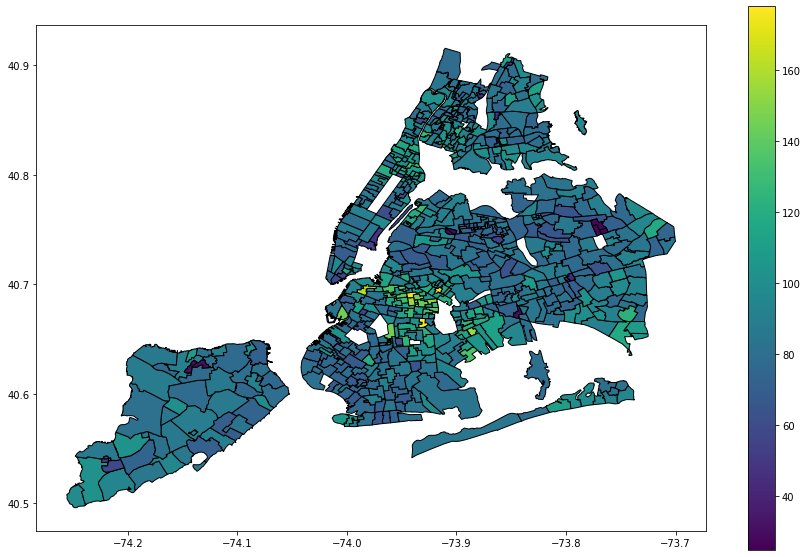

In [82]:
gdf.plot(edgecolor='black', column=space_with_school_zone.sq_ft_per_person, figsize=(15, 10), legend=True)